In [165]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

In [166]:
#settings
nr_examples_to_prepare = 2000
window_width_input_minutes = 60
window_width_output_minutes = 60*24

In [167]:
#The MLP will be trained e.g. on 2000/2=1000 training samples, 
#where the input window covers 60 minutes (1 hour of sensor data).
#The MLP input vector x length will be accordingly 60 minutes x 52 sensor samples/minute = a 3120-dimensional input vector.

#The MLP output vector y length is 1 (just one output neuron). 
#For checking whether there was a pump failure after the input window, 
#we check in some time window of length 60 x 24 (i.e. 1 day = 60 minutes * 24 hours), 
#whether the machine went into state "BROKEN" or "RECOVERING".

#1000 randomly extracted samples (x,y) will be used for training.
#1000 randomly extracted samples (x,y) will be used for testing.
#For generating one of these 2000 training samples we:
#i. randomly choose a sample minute
#ii. compute the input vector x from the input window starting at this minute
#iii. compute the output vector y by checking whether in the following time window the pump failed
#iV. combine both the input and output vector into one training sample (x,y)

In [168]:
df = pd.read_csv('sensor.csv')
df.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [169]:
# The first column has no name. Give it a name!
df.rename(columns={ df.columns[0]: "Samplenr" }, inplace = True)
df.head()

,Samplenr,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [170]:
possible_machine_states = list(df.machine_status.unique())
possible_machine_states

['NORMAL', 'BROKEN', 'RECOVERING']

In [171]:
# Get all rows where machine status was "NORMAL"
df_status_NORMAL = df[ df["machine_status"] == "NORMAL" ]

In [172]:
df_status_NORMAL.shape

(205836, 55)

In [173]:
nr_rows_machine_status_NORMAL = df_status_NORMAL.shape[0]
nr_rows_machine_status_NORMAL

205836

In [174]:
nr_rows_total = df.shape[0]
nr_rows_total

220320

In [175]:
percent_machine_status_NORMAL = (nr_rows_machine_status_NORMAL / nr_rows_total) * 100.0
percent_machine_status_NORMAL #this is base accuracy 94%

93.42592592592592

In [176]:
df_status_BROKEN = df[ df["machine_status"] == "BROKEN" ]
df_status_BROKEN

,Samplenr,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
17155,17155,2018-04-12 21:55:00,0.000000,53.342010,52.821180,43.402775,202.526031,49.79289,3.219039,16.890910,...,50.78125,50.92593,51.215280,50.636570,46.006940,409.143500,121.527800,401.909700,324.6528,BROKEN
24510,24510,2018-04-18 00:30:00,1.093982,42.534720,47.699650,41.449650,206.038757,60.30106,12.304690,15.154800,...,42.70833,34.72222,31.539350,34.432870,33.275460,59.895830,44.560180,177.662000,183.7384,BROKEN
69318,69318,2018-05-19 03:18:00,2.258796,47.265630,52.734370,43.446178,200.115738,66.14643,13.592300,15.914350,...,39.06250,35.01157,37.905090,39.062500,45.428240,144.675900,49.768520,246.238400,257.5231,BROKEN
77790,77790,2018-05-25 00:30:00,2.321759,47.482640,51.475693,42.795135,612.152800,67.30158,14.062500,16.608800,...,202.34370,65.68287,57.870370,127.893500,153.935200,155.381900,65.682870,220.196800,267.3611,BROKEN
128040,128040,2018-06-28 22:00:00,0.364005,40.190970,45.225690,40.190971,201.368622,0.00000,11.335360,15.270540,...,32.29166,28.06713,28.067129,29.513889,29.224537,29.224537,29.513889,32.407406,NaN,BROKEN
141131,141131,2018-07-08 00:11:00,0.001968,45.138890,52.907990,45.355900,500.000000,1.40131,0.028935,0.036169,...,36.19791,37.32639,35.300930,38.194440,43.402780,99.537030,44.849540,192.129600,174.7685,BROKEN
166440,166440,2018-07-25 14:00:00,2.318808,45.833332,52.994790,43.880210,420.503448,72.52040,14.185470,16.247110,...,51.30208,52.10200,52.662040,67.129630,43.981480,230.324100,69.733800,NaN,205.7292,BROKEN


In [177]:
nr_rows_machine_status_BROKEN = df_status_BROKEN.shape[0]
nr_rows_machine_status_BROKEN

7

In [178]:
print("So {0} times, the pump was broken".format(nr_rows_machine_status_BROKEN))

So 7 times, the pump was broken


In [179]:
df_status_RECOVERING = df[ df["machine_status"] == "RECOVERING" ]
nr_rows_machine_status_RECOVERING = df_status_RECOVERING.shape[0]
nr_rows_machine_status_RECOVERING

14477

In [180]:
percent_machine_status_RECOVERING = (nr_rows_machine_status_RECOVERING / nr_rows_total) * 100.0
percent_machine_status_RECOVERING

6.570896877269426

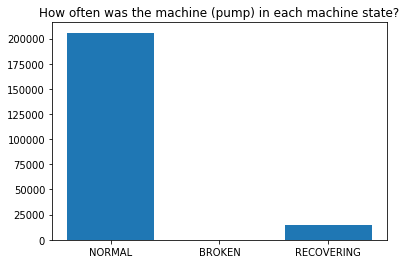

In [181]:
xpos = [1,2,3]
data = [nr_rows_machine_status_NORMAL, nr_rows_machine_status_BROKEN, nr_rows_machine_status_RECOVERING]

fig, ax = plt.subplots()
ax.bar(xpos,data)
ax.set_xticks(xpos)
ax.set_xticklabels(possible_machine_states)
ax.set_title("How often was the machine (pump) in each machine state?")
plt.show()

In [182]:
#How long did the 7 RECOVERING phases need?
row_numbers_machine_BROKEN = list(df_status_BROKEN["Samplenr"].values)
row_numbers_machine_BROKEN

[17155, 24510, 69318, 77790, 128040, 141131, 166440]

In [183]:
recovering_times_hours = []

for i in row_numbers_machine_BROKEN:
    print("\nMachine in status BROKEN in row: {0}".format(i) )
    
    go_further = True
    j = i
    while go_further:
        j += 1
        machine_status_in_row_j = df.iloc[j]["machine_status"]        
        if machine_status_in_row_j != "RECOVERING":
            go_further = False
            
    print("Machine went back to status {0} in row: {1}".format(machine_status_in_row_j, j-i))
    recovering_hours = (j-i)/60
    recovering_days  = recovering_hours / 24
    print("Machine was in RECOVERING state for {0:.1f} hours / {1:.1f} days".format( recovering_hours, recovering_days ))
    
    recovering_times_hours.append(recovering_hours)


Machine in status BROKEN in row: 17155
Machine went back to status NORMAL in row: 945
Machine was in RECOVERING state for 15.8 hours / 0.7 days

Machine in status BROKEN in row: 24510
Machine went back to status NORMAL in row: 3111
Machine was in RECOVERING state for 51.9 hours / 2.2 days

Machine in status BROKEN in row: 69318
Machine went back to status NORMAL in row: 1313
Machine was in RECOVERING state for 21.9 hours / 0.9 days

Machine in status BROKEN in row: 77790
Machine went back to status NORMAL in row: 606
Machine was in RECOVERING state for 10.1 hours / 0.4 days

Machine in status BROKEN in row: 128040
Machine went back to status NORMAL in row: 8391
Machine was in RECOVERING state for 139.8 hours / 5.8 days

Machine in status BROKEN in row: 141131
Machine went back to status NORMAL in row: 42
Machine was in RECOVERING state for 0.7 hours / 0.0 days

Machine in status BROKEN in row: 166440
Machine went back to status NORMAL in row: 76
Machine was in RECOVERING state for 1.3

In [184]:
recovering_times_hours

[15.75, 51.85, 21.883333333333333, 10.1, 139.85, 0.7, 1.2666666666666666]

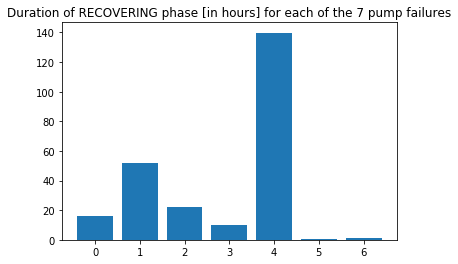

In [185]:
xpos = np.arange( len(recovering_times_hours) )

fig, ax = plt.subplots()
ax.bar(xpos,recovering_times_hours)
ax.set_xticks(xpos)
ax.set_xticklabels(xpos)
ax.set_title("Duration of RECOVERING phase [in hours] for each of the 7 pump failures")
plt.show()

In [186]:
print(min(recovering_times_hours),';',max(recovering_times_hours))

0.7 ; 139.85


In [187]:
#Visualize some of the sensor data
sensor_values = list( df["sensor_17"] )
len(sensor_values) #220320

220320

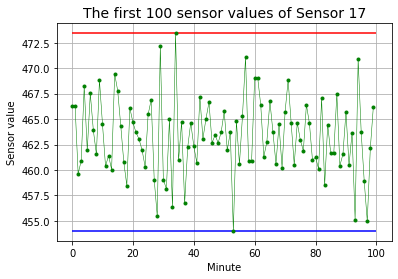

In [188]:
some_few_values = sensor_values[:100]
min_val = min(some_few_values)
max_val = max(some_few_values)

plt.plot( some_few_values, color="green", linestyle="-",
          marker=".", linewidth=0.5 )
plt.hlines(min_val, 0,100, color="blue")
plt.hlines(max_val, 0,100, color="red")
plt.xlabel("Minute", fontsize=10)
plt.ylabel("Sensor value", fontsize=10)
plt.title("The first 100 sensor values of Sensor 17", fontsize=14)
plt.grid()
#plt.savefig("sensor_17.png")
plt.show()

In [189]:
#How many missing values are there in total?
df.isna().sum().sum()

344574

In [190]:
df.isna().sum()

Samplenr               0
timestamp              0
sensor_00          10208
sensor_01            369
sensor_02             19
sensor_03             19
sensor_04             19
sensor_05             19
sensor_06           4798
sensor_07           5451
sensor_08           5107
sensor_09           4595
sensor_10             19
sensor_11             19
sensor_12             19
sensor_13             19
sensor_14             21
sensor_15         220320
sensor_16             31
sensor_17             46
sensor_18             46
sensor_19             16
sensor_20             16
sensor_21             16
sensor_22             41
sensor_23             16
sensor_24             16
sensor_25             36
sensor_26             20
sensor_27             16
sensor_28             16
sensor_29             72
sensor_30            261
sensor_31             16
sensor_32             68
sensor_33             16
sensor_34             16
sensor_35             16
sensor_36             16
sensor_37             16


In [191]:
only_numerical_cols = df.iloc[:,2:54]
only_numerical_cols

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
0,2.465394,47.092010,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889
1,2.465394,47.092010,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889
2,2.444734,47.352430,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,15.01013,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037
3,2.460474,47.092010,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,15.08247,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250
4,2.445718,47.135410,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,15.08247,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889
5,2.453588,47.092010,53.168400,46.397568,637.615700,78.18568,13.41146,16.16753,15.89265,15.16204,...,31.250000,42.70833,38.773150,63.65741,51.79398,38.773150,164.6412,66.55093,241.6088,201.6782
6,2.455556,47.048610,53.168400,46.397568,633.333300,75.81614,13.43316,16.13136,15.65393,15.08247,...,31.510420,43.22916,38.194440,61.92130,51.79398,39.062500,171.8750,67.70834,240.1620,200.2315
7,2.449653,47.135410,53.168400,46.397568,630.671300,75.77331,13.25231,16.12413,16.19647,15.08247,...,31.510416,42.96875,38.194443,59.60648,50.92593,39.351850,178.5301,68.57639,241.3194,201.0995
8,2.463426,47.092010,53.168400,46.397568,631.944400,74.58916,13.28848,16.13136,15.47309,15.11863,...,31.510416,42.18750,38.194440,57.87037,50.63657,39.351850,182.0023,69.44444,243.0556,201.6782
9,2.445718,47.178820,53.168400,46.397568,641.782300,74.57428,13.38252,16.24711,15.61777,15.11863,...,31.510416,41.66666,39.062500,56.42361,50.63657,39.062500,186.6319,69.73380,246.5278,200.8102


In [192]:
fill_value = -1.0
data_with_gaps_filled = df.fillna( fill_value )

In [193]:
data_with_gaps_filled.isna().sum().sum()

0

In [194]:
data_with_gaps_filled

,Samplenr,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.092010,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.092010,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.352430,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.092010,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.135410,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL
5,5,2018-04-01 00:05:00,2.453588,47.092010,53.168400,46.397568,637.615700,78.18568,13.41146,16.16753,...,42.70833,38.773150,63.65741,51.79398,38.773150,164.6412,66.55093,241.6088,201.6782,NORMAL
6,6,2018-04-01 00:06:00,2.455556,47.048610,53.168400,46.397568,633.333300,75.81614,13.43316,16.13136,...,43.22916,38.194440,61.92130,51.79398,39.062500,171.8750,67.70834,240.1620,200.2315,NORMAL
7,7,2018-04-01 00:07:00,2.449653,47.135410,53.168400,46.397568,630.671300,75.77331,13.25231,16.12413,...,42.96875,38.194443,59.60648,50.92593,39.351850,178.5301,68.57639,241.3194,201.0995,NORMAL
8,8,2018-04-01 00:08:00,2.463426,47.092010,53.168400,46.397568,631.944400,74.58916,13.28848,16.13136,...,42.18750,38.194440,57.87037,50.63657,39.351850,182.0023,69.44444,243.0556,201.6782,NORMAL
9,9,2018-04-01 00:09:00,2.445718,47.178820,53.168400,46.397568,641.782300,74.57428,13.38252,16.24711,...,41.66666,39.062500,56.42361,50.63657,39.062500,186.6319,69.73380,246.5278,200.8102,NORMAL


In [195]:
#Prepare data for training and testing
sensordata_cols_only = data_with_gaps_filled.iloc[:,2:54]
sensordata_cols_only

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
0,2.465394,47.092010,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889
1,2.465394,47.092010,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889
2,2.444734,47.352430,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,15.01013,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037
3,2.460474,47.092010,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,15.08247,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250
4,2.445718,47.135410,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,15.08247,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889
5,2.453588,47.092010,53.168400,46.397568,637.615700,78.18568,13.41146,16.16753,15.89265,15.16204,...,31.250000,42.70833,38.773150,63.65741,51.79398,38.773150,164.6412,66.55093,241.6088,201.6782
6,2.455556,47.048610,53.168400,46.397568,633.333300,75.81614,13.43316,16.13136,15.65393,15.08247,...,31.510420,43.22916,38.194440,61.92130,51.79398,39.062500,171.8750,67.70834,240.1620,200.2315
7,2.449653,47.135410,53.168400,46.397568,630.671300,75.77331,13.25231,16.12413,16.19647,15.08247,...,31.510416,42.96875,38.194443,59.60648,50.92593,39.351850,178.5301,68.57639,241.3194,201.0995
8,2.463426,47.092010,53.168400,46.397568,631.944400,74.58916,13.28848,16.13136,15.47309,15.11863,...,31.510416,42.18750,38.194440,57.87037,50.63657,39.351850,182.0023,69.44444,243.0556,201.6782
9,2.445718,47.178820,53.168400,46.397568,641.782300,74.57428,13.38252,16.24711,15.61777,15.11863,...,31.510416,41.66666,39.062500,56.42361,50.63657,39.062500,186.6319,69.73380,246.5278,200.8102


In [196]:
#Scale data column-wise to feature range [0,1]. 
#If all inputs are in the same range, it makes it easier for a MLP to learn.
from sklearn.preprocessing import MinMaxScaler

# create a MinMaxScaler with feature range [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sensor_data = scaler.fit_transform(sensordata_cols_only)
scaled_sensor_data

array([[0.97643798, 0.83308767, 0.95053407, ..., 0.1476298 , 0.24381179,
        0.20218671],
       [0.97643798, 0.83308767, 0.95053407, ..., 0.1476298 , 0.24381179,
        0.20218671],
       [0.97061664, 0.83759887, 0.95053407, ..., 0.14638636, 0.24207732,
        0.2044992 ],
       ...,
       [0.95703372, 0.84361368, 0.90335138, ..., 0.33600911, 0.        ,
        0.23282737],
       [0.95980576, 0.84361368, 0.90335141, ..., 0.33290067, 0.        ,
        0.23485075],
       [0.95703372, 0.84361368, 0.90335141, ..., 0.32544014, 0.        ,
        0.23485075]])

In [197]:
window_width_input_minutes = 60
window_width_output_minutes = 60*24

In [198]:
start_minute = 0
a_single_input_window = scaled_sensor_data[start_minute:start_minute+window_width_input_minutes]
a_single_input_window.shape

(60, 52)

In [199]:
# Map window to a vector, since we need a 1D input for the MLP
a_single_input_vector = a_single_input_window.flatten()
a_single_input_vector.shape

(3120,)

In [200]:
#How to check whether the pump failed in some time window in future after the input window
def check_for_pump_failure(start, stop):
    """
    Returns 1, if the pump failed in time window
    (start,stop)
    
    Returns 0, else.
    """
    for minute_count_after_start in range(start,stop):
        # get the corresponding row from the data
        machine_state_in_this_minute = df["machine_status"].iloc[minute_count_after_start]
        if machine_state_in_this_minute in ["BROKEN", "RECOVERING"]:
            return 1
    return 0

In [201]:
row_numbers_machine_BROKEN
#[17155, 24510, 69318, 77790, 128040, 141131, 166440]

[17155, 24510, 69318, 77790, 128040, 141131, 166440]

In [202]:
check_for_pump_failure(0,17000) #0 :means no failure
check_for_pump_failure(17000,17200) #1 :means failure occured

1

In [203]:
#Prepare example data
nr_rows_total #220320

220320

In [204]:
nr_examples_to_prepare

2000

In [205]:
# Max row nr such that input window and output window
# still fit into the time series data?
max_row_nr = nr_rows_total-window_width_input_minutes-window_width_output_minutes

# collect the desired number of (input_vec,output_vec) examples
training_pairs = []

#Iterate from 0 to 2000
for example_nr in range(0,nr_examples_to_prepare): 
    
    # show progress
    if example_nr % 100 == 0:
        print("Collected examples so far:", example_nr)
    
    # 1. guess a random minute
    found_example_where_pump_worked_in_input_window = False
    while not found_example_where_pump_worked_in_input_window:
    
        rnd_minute = np.random.randint(0,max_row_nr)
        
        # Make sure, the input window does not cover
        # already a phase where the machine is broken:
        # We want examples where the input window covers
        # a normal state and we want to predict whether
        # the pump will fail or not in the next time window
        # We do NOT want to collect examples where the machine is
        # already BROKEN in the input window
        # (could be too easy to predict whether the machine
        #  will be broken in the future as well)
        start = rnd_minute
        stop  = start+window_width_input_minutes
        if check_for_pump_failure(start,stop)==0:
            found_example_where_pump_worked_in_input_window = True
        
            # 2. get the input vector from the 2D sensor matrix data
            a_single_input_window = scaled_sensor_data[rnd_minute:rnd_minute+window_width_input_minutes]
            a_single_input_vector = a_single_input_window.flatten()
        
            # 3. check whether in time range
            #    (rnd_minute+window_width_input_minutes,
            #     rnd_minute+window_width_input_minutes+window_width_output_minutes)
            #    the pump failed
            start = rnd_minute+window_width_input_minutes
            stop  = rnd_minute+window_width_input_minutes+window_width_output_minutes
            output_value = check_for_pump_failure(start,stop)
        
            # 4. add a new training pair to list of training pairs
            training_pairs.append( (a_single_input_vector, output_value) )
            print(len(training_pairs))
        

Collected examples so far: 0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Collected examples so far: 100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
Collected examples so far: 200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
2

1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
Collected examples so far: 1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
Collected examples so far: 1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1

In [206]:
training_pairs

[(array([0.98641708, 0.85263609, 0.94368505, ..., 0.11467892, 0.18137423,
         0.19958511]), 0),
 (array([0.95148965, 0.83008026, 0.83866548, ..., 0.08981036, 0.        ,
         0.08251471]), 0),
 (array([0.98835762, 0.80226159, 0.93607489, ..., 0.11157036, 0.        ,
         0.18773357]), 0),
 (array([0.97061664, 0.87368795, 0.92085475, ..., 0.10535321, 0.22357732,
         0.17646014]), 0),
 (array([0.98613982, 0.87443983, 0.92389878, ..., 0.13333035, 0.21056953,
         0.2362961 ]), 0),
 (array([0.93291718, 0.81128382, 0.88660914, ..., 0.09851436, 0.16605385,
         0.17935075]), 0),
 (array([0.98863488, 0.83308768, 0.90487348, ..., 0.11219208, 0.        ,
         0.20536643]), 0),
 (array([0.98918912, 0.84135809, 0.91552757, ..., 0.09789263, 0.15102258,
         0.16113976]), 0),
 (array([0.98863488, 0.82707285, 0.96651534, ..., 0.12276121, 0.        ,
         0.18917892]), 0),
 (array([0.98724886, 0.88646958, 0.92694281, ..., 0.27197263, 0.        ,
         0.192069

In [207]:
len(training_pairs) #2000

2000

In [208]:
failure_count = 0
for i in range(len(training_pairs)):
    if((training_pairs[i][1]) == 1):
        failure_count +=1
    print(training_pairs[i][1])
print('failure_count:',failure_count)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
0
0
0
0
1
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [209]:
#Prepare a large example data matrix D from the list of training pairs
input_vec_len = training_pairs[0][0].shape[0] #3120
output_vec_len = 1

D = np.zeros( (nr_examples_to_prepare, input_vec_len+output_vec_len))
print("Shape of D is", D.shape)

# Fill data matrix D with input vec + output vec in each row
for nr in range(0,nr_examples_to_prepare):
    (x,y) = training_pairs[nr]
    D[nr,0:input_vec_len] = x
    D[nr,input_vec_len]   = y

Shape of D is (2000, 3121)


In [210]:
#From example data matrix get train and test matrices
nr_train_samples = int(nr_examples_to_prepare/2) #1000

xtrain = D[0:nr_train_samples, 0:input_vec_len]
ytrain = D[0:nr_train_samples, input_vec_len]

xtest = D[nr_train_samples:, 0:input_vec_len]
ytest = D[nr_train_samples:, input_vec_len]

In [211]:
ytest

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [212]:
ytrain.shape

(1000,)

In [213]:
#xtrain = xtrain.reshape(xtrain.shape[0], xtrain.shape[1], 1)
##ytrain = ytrain.reshape(ytrain.shape[0], 1)

#xtest = xtest.reshape(xtest.shape[0], xtest.shape[1], 1)
##ytest = ytest.reshape(ytest.shape[0], 1)

In [214]:
#xtrain = xtrain.reshape(xtrain.shape[0], xtrain.shape[1], 1)
#xtest = xtest.reshape(xtest.shape[0], xtest.shape[1], 1)

In [215]:
#Build MLP and train it

import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential()
model.add(layers.Dense(200, activation='relu', input_shape=(input_vec_len,)) )
model.add(layers.Dense(40, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='sgd', loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])
model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 200)               624200    
_________________________________________________________________
dense_4 (Dense)              (None, 40)                8040      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 41        
Total params: 632,281
Trainable params: 632,281
Non-trainable params: 0
_________________________________________________________________


In [216]:
model.fit(xtrain, ytrain, epochs=3000)

Train on 1000 samples
Epoch 1/3000
1000/1000 [==============================] - 1s 686us/sample - loss: 9.0822 - accuracy: 0.8630
Epoch 2/3000
1000/1000 [==============================] - 0s 121us/sample - loss: 0.0547 - accuracy: 0.9410
Epoch 3/3000
1000/1000 [==============================] - 0s 125us/sample - loss: 0.0547 - accuracy: 0.9410
Epoch 4/3000
1000/1000 [==============================] - 0s 125us/sample - loss: 0.0540 - accuracy: 0.9410
Epoch 5/3000
1000/1000 [==============================] - 0s 128us/sample - loss: 0.0542 - accuracy: 0.9410
Epoch 6/3000
1000/1000 [==============================] - 0s 125us/sample - loss: 0.0521 - accuracy: 0.9410
Epoch 7/3000
1000/1000 [==============================] - 0s 118us/sample - loss: 0.0540 - accuracy: 0.9410
Epoch 8/3000
1000/1000 [==============================] - 0s 126us/sample - loss: 0.0514 - accuracy: 0.9410
Epoch 9/3000
1000/1000 [==============================] - 0s 126us/sample - loss: 0.0518 - accuracy: 0.9410
Epoch 

1000/1000 [==============================] - 0s 140us/sample - loss: 0.0432 - accuracy: 0.9500
Epoch 77/3000
1000/1000 [==============================] - 0s 119us/sample - loss: 0.0428 - accuracy: 0.9500
Epoch 78/3000
1000/1000 [==============================] - 0s 129us/sample - loss: 0.0420 - accuracy: 0.9490
Epoch 79/3000
1000/1000 [==============================] - 0s 123us/sample - loss: 0.0426 - accuracy: 0.9510
Epoch 80/3000
1000/1000 [==============================] - 0s 121us/sample - loss: 0.0426 - accuracy: 0.9500
Epoch 81/3000
1000/1000 [==============================] - 0s 134us/sample - loss: 0.0444 - accuracy: 0.9510
Epoch 82/3000
1000/1000 [==============================] - 0s 138us/sample - loss: 0.0439 - accuracy: 0.9520
Epoch 83/3000
1000/1000 [==============================] - 0s 134us/sample - loss: 0.0414 - accuracy: 0.9520
Epoch 84/3000
1000/1000 [==============================] - 0s 128us/sample - loss: 0.0429 - accuracy: 0.9510
Epoch 85/3000
1000/1000 [========

1000/1000 [==============================] - 0s 121us/sample - loss: 0.0342 - accuracy: 0.9560
Epoch 225/3000
1000/1000 [==============================] - 0s 114us/sample - loss: 0.0339 - accuracy: 0.9550
Epoch 226/3000
1000/1000 [==============================] - 0s 116us/sample - loss: 0.0329 - accuracy: 0.9550
Epoch 227/3000
1000/1000 [==============================] - 0s 119us/sample - loss: 0.0334 - accuracy: 0.9580
Epoch 228/3000
1000/1000 [==============================] - 0s 118us/sample - loss: 0.0322 - accuracy: 0.9570
Epoch 229/3000
1000/1000 [==============================] - 0s 117us/sample - loss: 0.0398 - accuracy: 0.9480
Epoch 230/3000
1000/1000 [==============================] - 0s 117us/sample - loss: 0.0356 - accuracy: 0.9550
Epoch 231/3000
1000/1000 [==============================] - 0s 116us/sample - loss: 0.0334 - accuracy: 0.9570
Epoch 232/3000
1000/1000 [==============================] - 0s 124us/sample - loss: 0.0337 - accuracy: 0.9550
Epoch 233/3000
1000/1000 

1000/1000 [==============================] - 0s 123us/sample - loss: 0.0395 - accuracy: 0.9530
Epoch 373/3000
1000/1000 [==============================] - 0s 119us/sample - loss: 0.0352 - accuracy: 0.9530
Epoch 374/3000
1000/1000 [==============================] - 0s 120us/sample - loss: 0.0373 - accuracy: 0.9540
Epoch 375/3000
1000/1000 [==============================] - 0s 149us/sample - loss: 0.0360 - accuracy: 0.9540
Epoch 376/3000
1000/1000 [==============================] - 0s 143us/sample - loss: 0.0376 - accuracy: 0.9540
Epoch 377/3000
1000/1000 [==============================] - 0s 142us/sample - loss: 0.0349 - accuracy: 0.9540
Epoch 378/3000
1000/1000 [==============================] - 0s 128us/sample - loss: 0.0350 - accuracy: 0.9540
Epoch 379/3000
1000/1000 [==============================] - 0s 118us/sample - loss: 0.0349 - accuracy: 0.9540
Epoch 380/3000
1000/1000 [==============================] - 0s 118us/sample - loss: 0.0322 - accuracy: 0.9530
Epoch 381/3000
1000/1000 

1000/1000 [==============================] - 0s 127us/sample - loss: 0.0286 - accuracy: 0.9670
Epoch 520/3000
1000/1000 [==============================] - 0s 120us/sample - loss: 0.0321 - accuracy: 0.9620
Epoch 521/3000
1000/1000 [==============================] - 0s 118us/sample - loss: 0.0300 - accuracy: 0.9650
Epoch 522/3000
1000/1000 [==============================] - 0s 124us/sample - loss: 0.0274 - accuracy: 0.9660
Epoch 523/3000
1000/1000 [==============================] - 0s 131us/sample - loss: 0.0342 - accuracy: 0.9590
Epoch 524/3000
1000/1000 [==============================] - 0s 114us/sample - loss: 0.0281 - accuracy: 0.9660
Epoch 525/3000
1000/1000 [==============================] - 0s 134us/sample - loss: 0.0259 - accuracy: 0.9700
Epoch 526/3000
1000/1000 [==============================] - 0s 125us/sample - loss: 0.0303 - accuracy: 0.9640
Epoch 527/3000
1000/1000 [==============================] - 0s 139us/sample - loss: 0.0287 - accuracy: 0.9670
Epoch 528/3000
1000/1000 

1000/1000 [==============================] - 0s 137us/sample - loss: 0.0336 - accuracy: 0.9560
Epoch 667/3000
1000/1000 [==============================] - 0s 115us/sample - loss: 0.0342 - accuracy: 0.9550
Epoch 668/3000
1000/1000 [==============================] - 0s 120us/sample - loss: 0.0329 - accuracy: 0.9550
Epoch 669/3000
1000/1000 [==============================] - 0s 118us/sample - loss: 0.0350 - accuracy: 0.9530
Epoch 670/3000
1000/1000 [==============================] - 0s 117us/sample - loss: 0.0345 - accuracy: 0.9540
Epoch 671/3000
1000/1000 [==============================] - 0s 120us/sample - loss: 0.0346 - accuracy: 0.9540
Epoch 672/3000
1000/1000 [==============================] - 0s 169us/sample - loss: 0.0343 - accuracy: 0.9560
Epoch 673/3000
1000/1000 [==============================] - 0s 146us/sample - loss: 0.0339 - accuracy: 0.9550
Epoch 674/3000
1000/1000 [==============================] - 0s 124us/sample - loss: 0.0340 - accuracy: 0.9550
Epoch 675/3000
1000/1000 

1000/1000 [==============================] - 0s 148us/sample - loss: 0.0390 - accuracy: 0.9540
Epoch 814/3000
1000/1000 [==============================] - 0s 160us/sample - loss: 0.0365 - accuracy: 0.9540
Epoch 815/3000
1000/1000 [==============================] - 0s 171us/sample - loss: 0.0322 - accuracy: 0.9540
Epoch 816/3000
1000/1000 [==============================] - 0s 195us/sample - loss: 0.0326 - accuracy: 0.9540
Epoch 817/3000
1000/1000 [==============================] - 0s 171us/sample - loss: 0.0310 - accuracy: 0.9540
Epoch 818/3000
1000/1000 [==============================] - 0s 132us/sample - loss: 0.0317 - accuracy: 0.9540
Epoch 819/3000
1000/1000 [==============================] - 0s 170us/sample - loss: 0.0326 - accuracy: 0.9540 - loss: 0.0328 - accuracy: 0.
Epoch 820/3000
1000/1000 [==============================] - 0s 141us/sample - loss: 0.0330 - accuracy: 0.9540
Epoch 821/3000
1000/1000 [==============================] - 0s 147us/sample - loss: 0.0330 - accuracy: 0.

1000/1000 [==============================] - 0s 129us/sample - loss: 0.0245 - accuracy: 0.9720
Epoch 962/3000
1000/1000 [==============================] - 0s 124us/sample - loss: 0.0254 - accuracy: 0.9700
Epoch 963/3000
1000/1000 [==============================] - 0s 130us/sample - loss: 0.0250 - accuracy: 0.9710
Epoch 964/3000
1000/1000 [==============================] - 0s 124us/sample - loss: 0.0264 - accuracy: 0.9730
Epoch 965/3000
1000/1000 [==============================] - 0s 142us/sample - loss: 0.0247 - accuracy: 0.9700
Epoch 966/3000
1000/1000 [==============================] - 0s 154us/sample - loss: 0.0297 - accuracy: 0.9630
Epoch 967/3000
1000/1000 [==============================] - 0s 148us/sample - loss: 0.0282 - accuracy: 0.9650
Epoch 968/3000
1000/1000 [==============================] - 0s 141us/sample - loss: 0.0239 - accuracy: 0.9720
Epoch 969/3000
1000/1000 [==============================] - 0s 141us/sample - loss: 0.0245 - accuracy: 0.9670
Epoch 970/3000
1000/1000 

1000/1000 [==============================] - 0s 150us/sample - loss: 0.0386 - accuracy: 0.9530
Epoch 1109/3000
1000/1000 [==============================] - 0s 165us/sample - loss: 0.0378 - accuracy: 0.9540
Epoch 1110/3000
1000/1000 [==============================] - 0s 160us/sample - loss: 0.0383 - accuracy: 0.9530
Epoch 1111/3000
1000/1000 [==============================] - 0s 162us/sample - loss: 0.0372 - accuracy: 0.9540
Epoch 1112/3000
1000/1000 [==============================] - 0s 144us/sample - loss: 0.0375 - accuracy: 0.9540
Epoch 1113/3000
1000/1000 [==============================] - 0s 140us/sample - loss: 0.0373 - accuracy: 0.9540
Epoch 1114/3000
1000/1000 [==============================] - 0s 163us/sample - loss: 0.0375 - accuracy: 0.9550
Epoch 1115/3000
1000/1000 [==============================] - 0s 137us/sample - loss: 0.0373 - accuracy: 0.9550
Epoch 1116/3000
1000/1000 [==============================] - 0s 142us/sample - loss: 0.0375 - accuracy: 0.9550
Epoch 1117/3000
1

1000/1000 [==============================] - 0s 428us/sample - loss: 0.0327 - accuracy: 0.9620
Epoch 1254/3000
1000/1000 [==============================] - 0s 298us/sample - loss: 0.0340 - accuracy: 0.9610
Epoch 1255/3000
1000/1000 [==============================] - 0s 387us/sample - loss: 0.0299 - accuracy: 0.9650
Epoch 1256/3000
1000/1000 [==============================] - 0s 208us/sample - loss: 0.0541 - accuracy: 0.9370
Epoch 1257/3000
1000/1000 [==============================] - 0s 198us/sample - loss: 0.0388 - accuracy: 0.9560
Epoch 1258/3000
1000/1000 [==============================] - 0s 229us/sample - loss: 0.0352 - accuracy: 0.9570
Epoch 1259/3000
1000/1000 [==============================] - 0s 133us/sample - loss: 0.0323 - accuracy: 0.9630
Epoch 1260/3000
1000/1000 [==============================] - 0s 234us/sample - loss: 0.0323 - accuracy: 0.9630
Epoch 1261/3000
1000/1000 [==============================] - 0s 183us/sample - loss: 0.0335 - accuracy: 0.9610
Epoch 1262/3000
1

1000/1000 [==============================] - 0s 218us/sample - loss: 0.0277 - accuracy: 0.9660
Epoch 1400/3000
1000/1000 [==============================] - 0s 197us/sample - loss: 0.0312 - accuracy: 0.9620
Epoch 1401/3000
1000/1000 [==============================] - 0s 174us/sample - loss: 0.0288 - accuracy: 0.9650
Epoch 1402/3000
1000/1000 [==============================] - 0s 207us/sample - loss: 0.0323 - accuracy: 0.9600
Epoch 1403/3000
1000/1000 [==============================] - 0s 175us/sample - loss: 0.0277 - accuracy: 0.9670
Epoch 1404/3000
1000/1000 [==============================] - 0s 210us/sample - loss: 0.0303 - accuracy: 0.9600
Epoch 1405/3000
1000/1000 [==============================] - 0s 283us/sample - loss: 0.0278 - accuracy: 0.9670
Epoch 1406/3000
1000/1000 [==============================] - 0s 198us/sample - loss: 0.0275 - accuracy: 0.9680
Epoch 1407/3000
1000/1000 [==============================] - 0s 163us/sample - loss: 0.0295 - accuracy: 0.9670
Epoch 1408/3000
1

1000/1000 [==============================] - 0s 136us/sample - loss: 0.0396 - accuracy: 0.9540
Epoch 1546/3000
1000/1000 [==============================] - 0s 128us/sample - loss: 0.0398 - accuracy: 0.9540
Epoch 1547/3000
1000/1000 [==============================] - 0s 131us/sample - loss: 0.0402 - accuracy: 0.9540
Epoch 1548/3000
1000/1000 [==============================] - 0s 133us/sample - loss: 0.0400 - accuracy: 0.9540
Epoch 1549/3000
1000/1000 [==============================] - 0s 127us/sample - loss: 0.0398 - accuracy: 0.9540
Epoch 1550/3000
1000/1000 [==============================] - 0s 160us/sample - loss: 0.0398 - accuracy: 0.9540
Epoch 1551/3000
1000/1000 [==============================] - 0s 122us/sample - loss: 0.0409 - accuracy: 0.9540
Epoch 1552/3000
1000/1000 [==============================] - 0s 121us/sample - loss: 0.0394 - accuracy: 0.9540
Epoch 1553/3000
1000/1000 [==============================] - 0s 125us/sample - loss: 0.0398 - accuracy: 0.9540
Epoch 1554/3000
1

Epoch 1619/3000
1000/1000 [==============================] - 0s 127us/sample - loss: 0.0366 - accuracy: 0.9540
Epoch 1620/3000
1000/1000 [==============================] - 0s 132us/sample - loss: 0.0374 - accuracy: 0.9540
Epoch 1621/3000
1000/1000 [==============================] - 0s 127us/sample - loss: 0.0374 - accuracy: 0.9540
Epoch 1622/3000
1000/1000 [==============================] - 0s 126us/sample - loss: 0.0373 - accuracy: 0.9540
Epoch 1623/3000
1000/1000 [==============================] - 0s 127us/sample - loss: 0.0377 - accuracy: 0.9540
Epoch 1624/3000
1000/1000 [==============================] - 0s 129us/sample - loss: 0.0371 - accuracy: 0.9540
Epoch 1625/3000
1000/1000 [==============================] - 0s 127us/sample - loss: 0.0371 - accuracy: 0.9540
Epoch 1626/3000
1000/1000 [==============================] - 0s 133us/sample - loss: 0.0381 - accuracy: 0.9540 - loss: 0.0376 - accuracy: 0.
Epoch 1627/3000
1000/1000 [==============================] - 0s 128us/sample - los

1000/1000 [==============================] - 0s 132us/sample - loss: 0.0320 - accuracy: 0.9590
Epoch 1766/3000
1000/1000 [==============================] - 0s 123us/sample - loss: 0.0344 - accuracy: 0.9570
Epoch 1767/3000
1000/1000 [==============================] - 0s 126us/sample - loss: 0.0336 - accuracy: 0.9600
Epoch 1768/3000
1000/1000 [==============================] - 0s 122us/sample - loss: 0.0321 - accuracy: 0.9590
Epoch 1769/3000
1000/1000 [==============================] - 0s 123us/sample - loss: 0.0312 - accuracy: 0.9610
Epoch 1770/3000
1000/1000 [==============================] - 0s 125us/sample - loss: 0.0331 - accuracy: 0.9590
Epoch 1771/3000
1000/1000 [==============================] - 0s 123us/sample - loss: 0.0337 - accuracy: 0.9600
Epoch 1772/3000
1000/1000 [==============================] - 0s 121us/sample - loss: 0.0334 - accuracy: 0.9600
Epoch 1773/3000
1000/1000 [==============================] - 0s 120us/sample - loss: 0.0325 - accuracy: 0.9600
Epoch 1774/3000
1

Epoch 1839/3000
1000/1000 [==============================] - 0s 126us/sample - loss: 0.0377 - accuracy: 0.9550
Epoch 1840/3000
1000/1000 [==============================] - 0s 161us/sample - loss: 0.0331 - accuracy: 0.9590
Epoch 1841/3000
1000/1000 [==============================] - 0s 136us/sample - loss: 0.0308 - accuracy: 0.9660
Epoch 1842/3000
1000/1000 [==============================] - 0s 138us/sample - loss: 0.0284 - accuracy: 0.9630
Epoch 1843/3000
1000/1000 [==============================] - 0s 129us/sample - loss: 0.0290 - accuracy: 0.9650
Epoch 1844/3000
1000/1000 [==============================] - 0s 128us/sample - loss: 0.0290 - accuracy: 0.9620
Epoch 1845/3000
1000/1000 [==============================] - 0s 124us/sample - loss: 0.0366 - accuracy: 0.9570
Epoch 1846/3000
1000/1000 [==============================] - 0s 129us/sample - loss: 0.0297 - accuracy: 0.9600
Epoch 1847/3000
1000/1000 [==============================] - 0s 139us/sample - loss: 0.0279 - accuracy: 0.9620
E

1000/1000 [==============================] - 0s 168us/sample - loss: 0.0240 - accuracy: 0.9680
Epoch 1986/3000
1000/1000 [==============================] - 0s 154us/sample - loss: 0.0240 - accuracy: 0.9690
Epoch 1987/3000
1000/1000 [==============================] - 0s 241us/sample - loss: 0.0233 - accuracy: 0.9720
Epoch 1988/3000
1000/1000 [==============================] - 0s 209us/sample - loss: 0.0292 - accuracy: 0.9630
Epoch 1989/3000
1000/1000 [==============================] - 0s 146us/sample - loss: 0.0224 - accuracy: 0.9690
Epoch 1990/3000
1000/1000 [==============================] - 0s 150us/sample - loss: 0.0291 - accuracy: 0.9680
Epoch 1991/3000
1000/1000 [==============================] - 0s 146us/sample - loss: 0.0236 - accuracy: 0.9710
Epoch 1992/3000
1000/1000 [==============================] - 0s 186us/sample - loss: 0.0233 - accuracy: 0.9690
Epoch 1993/3000
1000/1000 [==============================] - 0s 178us/sample - loss: 0.0292 - accuracy: 0.9660
Epoch 1994/3000
1

Epoch 2059/3000
1000/1000 [==============================] - 0s 129us/sample - loss: 0.0216 - accuracy: 0.9700
Epoch 2060/3000
1000/1000 [==============================] - 0s 135us/sample - loss: 0.0223 - accuracy: 0.9730
Epoch 2061/3000
1000/1000 [==============================] - 0s 134us/sample - loss: 0.0220 - accuracy: 0.9750
Epoch 2062/3000
1000/1000 [==============================] - 0s 131us/sample - loss: 0.0235 - accuracy: 0.9710
Epoch 2063/3000
1000/1000 [==============================] - 0s 134us/sample - loss: 0.0316 - accuracy: 0.9600
Epoch 2064/3000
1000/1000 [==============================] - 0s 132us/sample - loss: 0.0241 - accuracy: 0.9670
Epoch 2065/3000
1000/1000 [==============================] - 0s 135us/sample - loss: 0.0204 - accuracy: 0.9770
Epoch 2066/3000
1000/1000 [==============================] - 0s 128us/sample - loss: 0.0243 - accuracy: 0.9710
Epoch 2067/3000
1000/1000 [==============================] - 0s 129us/sample - loss: 0.0223 - accuracy: 0.9740
E

1000/1000 [==============================] - 0s 128us/sample - loss: 0.0205 - accuracy: 0.9760
Epoch 2206/3000
1000/1000 [==============================] - 0s 128us/sample - loss: 0.0210 - accuracy: 0.9770
Epoch 2207/3000
1000/1000 [==============================] - 0s 130us/sample - loss: 0.0226 - accuracy: 0.9670
Epoch 2208/3000
1000/1000 [==============================] - 0s 128us/sample - loss: 0.0192 - accuracy: 0.9760
Epoch 2209/3000
1000/1000 [==============================] - 0s 128us/sample - loss: 0.0207 - accuracy: 0.9720
Epoch 2210/3000
1000/1000 [==============================] - 0s 129us/sample - loss: 0.0291 - accuracy: 0.9640
Epoch 2211/3000
1000/1000 [==============================] - 0s 141us/sample - loss: 0.0174 - accuracy: 0.9770
Epoch 2212/3000
1000/1000 [==============================] - 0s 128us/sample - loss: 0.0190 - accuracy: 0.9780
Epoch 2213/3000
1000/1000 [==============================] - 0s 130us/sample - loss: 0.0183 - accuracy: 0.9770
Epoch 2214/3000
1

1000/1000 [==============================] - 0s 121us/sample - loss: 0.0161 - accuracy: 0.9780
Epoch 2352/3000
1000/1000 [==============================] - 0s 124us/sample - loss: 0.0159 - accuracy: 0.9800
Epoch 2353/3000
1000/1000 [==============================] - 0s 124us/sample - loss: 0.0169 - accuracy: 0.9780
Epoch 2354/3000
1000/1000 [==============================] - 0s 130us/sample - loss: 0.0217 - accuracy: 0.9740
Epoch 2355/3000
1000/1000 [==============================] - 0s 136us/sample - loss: 0.0212 - accuracy: 0.9730
Epoch 2356/3000
1000/1000 [==============================] - 0s 122us/sample - loss: 0.0194 - accuracy: 0.9750
Epoch 2357/3000
1000/1000 [==============================] - 0s 134us/sample - loss: 0.0202 - accuracy: 0.9780
Epoch 2358/3000
1000/1000 [==============================] - 0s 132us/sample - loss: 0.0155 - accuracy: 0.9810
Epoch 2359/3000
1000/1000 [==============================] - 0s 135us/sample - loss: 0.0179 - accuracy: 0.9750
Epoch 2360/3000
1

Epoch 2498/3000
1000/1000 [==============================] - 0s 124us/sample - loss: 0.0168 - accuracy: 0.9800 - loss: 0.0171 - accuracy: 0.98
Epoch 2499/3000
1000/1000 [==============================] - 0s 123us/sample - loss: 0.0163 - accuracy: 0.9770
Epoch 2500/3000
1000/1000 [==============================] - 0s 124us/sample - loss: 0.0151 - accuracy: 0.9800
Epoch 2501/3000
1000/1000 [==============================] - 0s 122us/sample - loss: 0.0212 - accuracy: 0.9720 - loss: 0.0186 - accuracy: 0.97
Epoch 2502/3000
1000/1000 [==============================] - 0s 122us/sample - loss: 0.0213 - accuracy: 0.9750
Epoch 2503/3000
1000/1000 [==============================] - 0s 141us/sample - loss: 0.0161 - accuracy: 0.9790
Epoch 2504/3000
1000/1000 [==============================] - 0s 133us/sample - loss: 0.0181 - accuracy: 0.9770
Epoch 2505/3000
1000/1000 [==============================] - 0s 123us/sample - loss: 0.0224 - accuracy: 0.9720
Epoch 2506/3000
1000/1000 [=====================

Epoch 2571/3000
1000/1000 [==============================] - 0s 126us/sample - loss: 0.0171 - accuracy: 0.9790
Epoch 2572/3000
1000/1000 [==============================] - 0s 121us/sample - loss: 0.0223 - accuracy: 0.9700
Epoch 2573/3000
1000/1000 [==============================] - 0s 133us/sample - loss: 0.0154 - accuracy: 0.9780
Epoch 2574/3000
1000/1000 [==============================] - 0s 132us/sample - loss: 0.0216 - accuracy: 0.9720
Epoch 2575/3000
1000/1000 [==============================] - 0s 126us/sample - loss: 0.0171 - accuracy: 0.9760
Epoch 2576/3000
1000/1000 [==============================] - 0s 130us/sample - loss: 0.0165 - accuracy: 0.9770
Epoch 2577/3000
1000/1000 [==============================] - 0s 120us/sample - loss: 0.0159 - accuracy: 0.9780
Epoch 2578/3000
1000/1000 [==============================] - 0s 127us/sample - loss: 0.0232 - accuracy: 0.9650
Epoch 2579/3000
1000/1000 [==============================] - 0s 124us/sample - loss: 0.0164 - accuracy: 0.9770
E

Epoch 2718/3000
1000/1000 [==============================] - 0s 117us/sample - loss: 0.0135 - accuracy: 0.9810 - loss: 0.0163 - accuracy: 0.
Epoch 2719/3000
1000/1000 [==============================] - 0s 120us/sample - loss: 0.0168 - accuracy: 0.9760
Epoch 2720/3000
1000/1000 [==============================] - 0s 125us/sample - loss: 0.0133 - accuracy: 0.9850
Epoch 2721/3000
1000/1000 [==============================] - 0s 117us/sample - loss: 0.0201 - accuracy: 0.9740
Epoch 2722/3000
1000/1000 [==============================] - 0s 117us/sample - loss: 0.0190 - accuracy: 0.9720
Epoch 2723/3000
1000/1000 [==============================] - 0s 118us/sample - loss: 0.0136 - accuracy: 0.9780
Epoch 2724/3000
1000/1000 [==============================] - 0s 120us/sample - loss: 0.0154 - accuracy: 0.9800
Epoch 2725/3000
1000/1000 [==============================] - 0s 117us/sample - loss: 0.0133 - accuracy: 0.9850
Epoch 2726/3000
1000/1000 [==============================] - 0s 117us/sample - los

1000/1000 [==============================] - 0s 124us/sample - loss: 0.0131 - accuracy: 0.9820
Epoch 2864/3000
1000/1000 [==============================] - 0s 118us/sample - loss: 0.0266 - accuracy: 0.9690
Epoch 2865/3000
1000/1000 [==============================] - 0s 118us/sample - loss: 0.0193 - accuracy: 0.9740
Epoch 2866/3000
1000/1000 [==============================] - 0s 116us/sample - loss: 0.0168 - accuracy: 0.9790
Epoch 2867/3000
1000/1000 [==============================] - 0s 120us/sample - loss: 0.0159 - accuracy: 0.9730
Epoch 2868/3000
1000/1000 [==============================] - 0s 118us/sample - loss: 0.0199 - accuracy: 0.9760
Epoch 2869/3000
1000/1000 [==============================] - 0s 121us/sample - loss: 0.0111 - accuracy: 0.9880
Epoch 2870/3000
1000/1000 [==============================] - 0s 120us/sample - loss: 0.0152 - accuracy: 0.9810
Epoch 2871/3000
1000/1000 [==============================] - 0s 119us/sample - loss: 0.0115 - accuracy: 0.9900
Epoch 2872/3000
1

In [217]:
input_vec_len

3120

In [218]:
#Build Keras Sequential Model
#import keras
#from keras.models import Sequential
#from keras.layers import Dense, Dropout
#from keras.callbacks import EarlyStopping

#n_features = 1

#model = Sequential()
#model.add(Dense(200, activation='relu', input_shape=(input_vec_len,)) )
#model.add(Dense(40, activation='relu'))
#model.add(Dense(1))

#model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
#model.build()
#model.summary()

#early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

In [219]:
#model.fit(x=xtrain, y=ytrain, epochs=3000, validation_data=(xtest, ytest), verbose=1, callbacks=[early_stop])

In [220]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,accuracy
0,9.082239,0.863
1,0.054715,0.941
2,0.054690,0.941
3,0.054011,0.941
4,0.054223,0.941


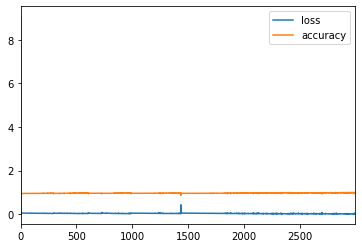

In [221]:
#loss = model_loss[['loss','val_loss']]
#loss.plot()
model_loss.plot()

In [222]:
#Predict on Test Set
preds = model.predict(xtest)

In [223]:
preds = preds.flatten()
preds.shape

(1000,)

In [224]:
print(min(preds),';',max(preds))

-0.32130808 ; 1.3573138


In [228]:
for i in range(len(preds)):
    if(preds[i] >= 0.5):
        print(preds[i])

0.81593895
0.88152266
0.5577708
1.0465612
0.66131186
0.59473395
0.74725044
0.6906464
1.3573138


In [229]:
preds

array([-8.43986869e-03, -9.78791714e-03, -6.30503893e-03, -2.54390240e-02,
       -9.68718529e-03, -6.25613332e-03,  5.53613007e-02, -2.83335149e-03,
       -2.99360752e-02, -2.04613179e-01, -1.76331401e-02, -5.84754944e-02,
        3.00185382e-03,  2.90200114e-03,  9.15670395e-02, -1.01466477e-02,
        1.89943820e-01, -6.38025999e-03, -6.62594438e-02, -4.64126468e-03,
       -3.01602483e-03,  8.44673216e-02, -2.95858085e-03, -2.24906206e-03,
       -7.59714842e-03, -6.88099861e-03, -4.26562130e-03, -9.36695933e-03,
       -1.08444512e-01, -1.14226162e-01, -3.14517319e-03, -9.76487994e-03,
       -7.31880963e-02, -1.68760121e-03, -5.66911697e-03, -9.23478603e-03,
       -9.41869617e-03, -8.26343894e-03, -1.04196370e-02, -1.01059973e-02,
       -3.95095348e-03,  8.51750076e-02, -2.67130136e-03,  1.51506022e-01,
       -5.71125746e-03, -6.35229051e-03, -9.64910537e-02, -5.79929352e-03,
       -8.26457441e-02, -6.76536560e-03,  3.63233685e-03, -6.53412938e-03,
       -8.32310319e-03, -

In [231]:
pump_failure_in_future_window = 0
correctly_predicted_pump_failures = 0
correctly_predicted = 0
nr_test_samples = preds.shape[0]

tp = 0
tn = 0
fp = 0
fn = 0

for test_nr in range(0,nr_test_samples):
    ground_truth_output = ytest[test_nr]
    if preds[test_nr] < 0.5:
        predicted_output = 0.0
    else:
        predicted_output = 1.0
    
    print("Test example #{0}: ground truth vs. predicted machine status: {1} vs. {2}"
          .format(test_nr, ground_truth_output, predicted_output ))
    
    if predicted_output == ground_truth_output:
        correctly_predicted +=1
        
    if ground_truth_output==1:
        pump_failure_in_future_window += 1
        if predicted_output == ground_truth_output:
            correctly_predicted_pump_failures +=1
            
    if ground_truth_output==1:
        if predicted_output == ground_truth_output:
            # True positive:
            # There was a pump failure
            # and the MLP predictor predicted it
            tp+=1
        else:
            # False negative:
            # There was a pump failure
            # BUT the MLP predictor predicted it not
            fn+=1
            
    if ground_truth_output==0:        
        if predicted_output == ground_truth_output:
            # True negative:
            # There was no pump failure
            # and the MLP predictor predicted no pump failure
            tn+=1
        else:
            # False positive:
            # There was no pump failure
            # BUT the MLP predictor predicted a pump failure
            fp+=1
            
            
correct_classification_percent = (correctly_predicted/nr_test_samples)*100.0
print("\nCorrectly predicted {0} of {1} test examples --> {2}%"
      .format(correctly_predicted, nr_test_samples, correct_classification_percent))

print("\nIf there was really a pump failure in the future window,\n"
      "the MLP could predict it in {0} of the {1} pump failure (in future window) example cases."
      .format(correctly_predicted_pump_failures, pump_failure_in_future_window))

print("True positive:", tp)
print("True negative:", tn)
print("False positive:", fp)
print("False negative:", fn)

Test example #0: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #1: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #2: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #3: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #4: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #5: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #6: ground truth vs. predicted machine status: 1.0 vs. 0.0
Test example #7: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #8: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #9: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #10: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #11: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #12: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #13: ground truth vs. predicted machine status: 

In [232]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print("Precision: {0:.2f}".format(precision))
print("Recall   : {0:.2f}".format(recall))

Precision: 0.78
Recall   : 0.18


In [233]:
print("The machine status can be predicted with an accuracy of {0}%".format(correct_classification_percent))

The machine status can be predicted with an accuracy of 96.6%


In [ ]:
#END